In [115]:
#load packages
import os, sys,cv2,re
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.integrate as integrate
from PyQt5 import QtWidgets, QtGui
from PyQt5.uic import loadUi
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing import image
from sklearn import svm

In [157]:
#This section defines a few customised function.
'''
The following functions are carefully designed. Some functions that might be repetitively called, 
or optional functionalities are seperated from the main section. Also, these functions might share
a few parameters with main section. Carefully define them will save some space.
'''

#HDR Process
def HDR(folders_path,img_shape=(800,450)):
    #This function takes a folder path to HDR folders, each of them must contains exactly 3 photos.
    #(They are usually over, normal, under exposure photos.)
    #It will return merged photos to the folder that user input.
    
    #prevent from entering non-exist folder path
    assert os.path.exists(folders_path), "The folder path you input is not right. Please check it!"
      
    for root, dirs, files in os.walk(folders_path):
        if not dirs: #make sure at the bottom level the directory
            #read image files into a list
            img_list=[]
            for i in range(len(files)):
                path = os.path.join(folders_path,root,files[i]) #concatenate parts into a file path
                img_list.append(cv2.imread(path))
                img_list[i] = cv2.resize(img_list[i],img_shape) #reduce processing time
        
            #HDR merge process
            merge_mertens = cv2.createMergeMertens() #create a merge instance
            img_hdr = merge_mertens.process(img_list) #merge the three imgs (value [0,1])
            img_hdr_8bits = np.clip(img_hdr*255,0,255).astype('uint8') #convert the range back to [0,255], integer
                
            #save the image, took part of first_original filename
            hdr_name = re.findall("\S+(?=\.)",files[0])
            hdr_name = hdr_name[0] + "_hdr.jpg" #add suffix to original filename and turn it to str
            path = os.path.join(folders_path,hdr_name)
            cv2.imwrite(path,img_hdr_8bits)

#Data preprocessing
def grid_cropping(img_folder,destination,shape=(800,450), d_h=150,d_w=100):
    #This function takes a folder with photos to be cropped.
    #The photos will be cropped into  (width/d_w)*(height/d_h) sub photos.
    #image shape and d_h, d_w are related parameters, use can change them. Just to avoid "small d_x"(too many crops) and fraction part of height(or width) when divided.
    
    #prevent from entering non-exist folder path
    assert os.path.exists(img_folder), "The folder path you input is not right. Please check it!"
    
    #load images from folder
    for s in os.listdir(img_folder):
        path = os.path.join(img_folder,s)
        img = cv2.imread(path)
        img = cv2.resize(img,shape) #put a hard dimension on input image
        h_span = int(shape[1]/d_h)
        w_span = int(shape[0]/d_w)  #to maintain the aspect ration, set "window" as 100*150     
        
        if h_span * w_span >200: #a simple idiot proof, too avoid over cropping which might leads to crashing
            print("Too many crops, please adjust parameter d")
        else:
            #shows how many sub-photos will be produced
            print(f'This will produce {h_span*w_span} sub-photos')
        
        filename_root = re.findall("\S+(?=\.)",s)

        #cropping
        for i in range(h_span+1):
            for j in range(w_span+1):
                filename = filename_root[0] + "_" + str(i) + "_" + str(j) +".jpg"
                filename = os.path.join(destination,filename)
                cv2.imwrite(filename, img[i*d_h:(i+1)*d_h-1,j*d_w:(j+1)*d_w-1])
    
    #create a log_file for gathering other info
    cropped_file_list = os.listdir(destination)
    temp = {"window_name":cropped_file_list,"t_amb":"", "t_dew":"","qnh":"",
            "cloud_height":"","lux":"","hh_z":"","is_ROI":""} #add column names
    temp = pd.DataFrame(temp)
    temp.to_csv(os.path.join(destination, "log_book.csv"),index=False)
    del temp
    print("Cropping was done!")
    
def rh_calculator(T_am,T_dew):
    #This function takes ambient temperature and dew point, then calculate the relative humidity(RH) of the atmosphere, at surface level.
    '''
           6.1078 * Exp( (17.27 * Td) / (237.3 + Td) )
     Rh=   ──────────────────────────────────────────────* 100%
           6.112  * Exp( (17.67 * T) / (243.5 + T) )
    '''
    numerator = 6.1078*np.exp((17.27*T_dew)/(237.3+T_am))
    denominator = 6.112*np.exp((17.67*T_am)/(243.5+T_am))
    
    return numerator/denominator

def regression_history_plot(train_history):
    #This function takes keras training history, and then plots training loss history.
    os.environ["KMP_DUPLICATE_LIB_OK"] = "True" #temporary skip conflicting issue of matlibplot
    plt.plot(train_history.history['loss'])
    plt.plot(train_history.history['val_loss'])
    plt.ylabel('loss',labelpad=5)
    plt.xlabel('epoch',labelpad=5)
    plt.legend(['train','validation'])
    plt.show()
    os.environ["KMP_DUPLICATE_LIB_OK"] = "False" #restore setting
    
def draw_img(img):
    #draw images with given label(can be filename, categorical factor, etc.)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    return

In [ ]:
#grid_cropping(img_folder,destination,shape=(800,450), d_h=150,d_w=100):
img_folder = "C:/Users/folia/metar_project/images/IR_filtered/train"
destination_folder = "C:/Users/folia/metar_project/images/IR_filtered/train_cropped"
grid_cropping(img_folder,destination_folder)

In [4]:
#Stage I: test a classic CNN model with regression output.

#Data preparation
##load dataframe prepared 
train_folder = "C:/Users/folia/metar_project/images/filtered/filtered_train_cropped"
df = pd.read_excel("C:/Users/folia/metar_project/images/filtered/filtered_train_cropped/filtered_train.xlsx")
df = df.sample(frac=1) #random shuffle for dataframe, just to cut off smilarities between "windows" and let model learn more complex patterns

vali_pct = 0.8
vali_cut = int(len(df)*vali_pct)

##divide into training and validation parts
df_train = df[0:vali_cut]
df_vali = df[vali_cut:]
vali_steps = len(df_vali)

##training data generator-to preprocess images on the fly, which saves memory of computer
train_gen_spec = image.ImageDataGenerator(rescale = 1./255,
                                  horizontal_flip=True,
                                  vertical_flip=True)
train_generator = train_gen_spec.flow_from_dataframe(dataframe = df_train,
                                                         directory = train_folder,
                                                         x_col = "window_name",
                                                         y_col = "cloud_height",
                                                         target_size = (150,100),
                                                         batch_size = 2,
                                                         class_mode = "other")

vali_gen_spec = image.ImageDataGenerator(rescale = 1./255)
vali_generator = vali_gen_spec.flow_from_dataframe(dataframe = df_vali,
                                                         directory = train_folder,
                                                         x_col = "window_name",
                                                         y_col = "cloud_height",
                                                         target_size = (150,100),
                                                         batch_size = 2,
                                                         class_mode = "other")

Found 272 validated image filenames.
Found 68 validated image filenames.


In [121]:
#build neural network
##build convnet for only one input (photos) regression using functional API 
inputs = keras.Input(shape=(150,100,3),name = "window_input")
hidden_layers = layers.Conv2D(filters = 32, kernel_size = 5, activation = "relu")(inputs)
hidden_layers = layers.MaxPooling2D(pool_size=3)(hidden_layers)
hidden_layers = layers.Conv2D(filters = 64, kernel_size = 5, activation = "relu")(hidden_layers)
hidden_layers = layers.MaxPooling2D(pool_size=3)(hidden_layers)
hidden_layers = layers.Flatten()(hidden_layers)
hidden_layers = layers.Dense(256,activation = "relu")(hidden_layers)
outputs = layers.Dense(1,activation = "linear")(hidden_layers) #for regression purpose, adapt "linear" activation method

model = keras.Model(inputs = inputs, outputs = outputs)
model.summary()
model.compile(loss = "mean_squared_error", optimizer = "adam")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 window_input (InputLayer)   [(None, 150, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 146, 96, 32)       2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 28, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 9, 64)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 8064)              0     

In [122]:
#fit the data into model
history = model.fit(x= train_generator, epochs=8, verbose=1, validation_data = vali_generator)

Epoch 1/8
136/136 [==============================] - 4s 25ms/step - loss: 8624.1953 - val_loss: 7094.0991
Epoch 2/8
136/136 [==============================] - 3s 23ms/step - loss: 6311.4629 - val_loss: 5277.4609
Epoch 3/8
136/136 [==============================] - 3s 23ms/step - loss: 4545.5283 - val_loss: 3340.0278
Epoch 4/8
136/136 [==============================] - 3s 23ms/step - loss: 3345.4136 - val_loss: 3232.6353
Epoch 5/8
136/136 [==============================] - 3s 24ms/step - loss: 3657.4915 - val_loss: 3261.4277
Epoch 6/8
136/136 [==============================] - 3s 22ms/step - loss: 3633.6279 - val_loss: 4043.8157
Epoch 7/8
136/136 [==============================] - 3s 23ms/step - loss: 3490.3020 - val_loss: 3239.6987
Epoch 8/8
136/136 [==============================] - 3s 22ms/step - loss: 3368.1863 - val_loss: 3209.0730


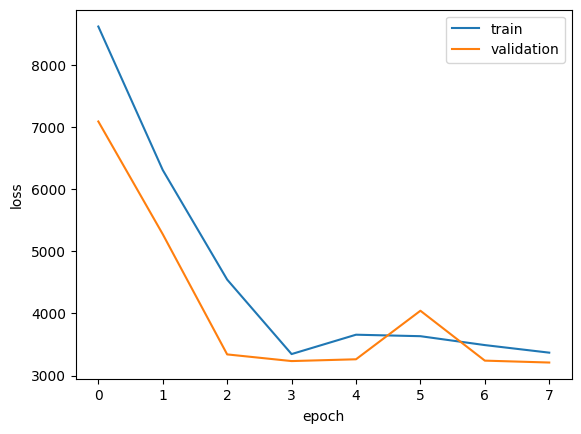

In [123]:
regression_history_plot(history)

In [124]:
#evaluate the regression model
df_test = pd.read_excel("C:/Users/folia/metar_project/images/filtered/filtered_test_cropped/filtered_test.xlsx")
test_folder = "C:/Users/folia/metar_project/images/filtered/filtered_test_cropped"


##prepare test data generator
test_gen_spec = image.ImageDataGenerator(rescale=1./255)

test_generator = test_gen_spec.flow_from_dataframe(dataframe=df_test,
                                                  directory = test_folder,
                                                  x_col="window_name",
                                                  target_size=(150,100),
                                                  batch_size=1,
                                                  class_mode= None)
test_generator.reset() #reset the generator before putting in, make sure the memory is clear

##make predictions using model trained
pred = model.predict(x=test_generator, steps = len(df_test)) #return a 1D array consist of predicted values
cloud_height_pred = pred.flatten().astype(int) #remove fractions

###write the predicted values into a csv file
df_pred_result = pd.DataFrame({"window_name":df_test['window_name'], "y_pred":cloud_height_pred, "y_true":df_test["cloud_height"]})
df_pred_result.to_csv(os.path.join(test_folder,"predicts.csv"))

Found 178 validated image filenames.
178/178 [==============================] - 2s 8ms/step


The Mean square error of model 1 is 7009.32
Check the 10 largest error are                          window_name  y_pred  y_true  prediction_error
174                  6-IR-N_2_4.jpg     182      25               157
128  20231123-141850_normal_1_3.jpg     168      25               143
165                  6-IR-N_1_1.jpg     164      25               139
17                    1228N_2_1.jpg      68     200               132
52          1310-HDR_normal_0_4.jpg      68     200               132
59          1310-HDR_normal_1_3.jpg      68     200               132
65          1310-HDR_normal_2_1.jpg      68     200               132
68          1310-HDR_normal_2_4.jpg      68     200               132
80         20231120-154428N_1_0.jpg     187      55               132
101        20231120-154755N_1_1.jpg      68     200               132


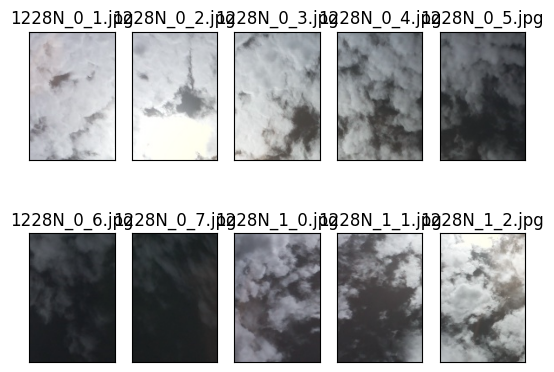

'\nLarge error result from two scenarios:\n1. high exposure area: high exposure area may leads to a "flatten" texture, which is similar to bright sky.\n2.edge of cloud: some small parts of cloud may be recognised as high clouds such as Cirrocumulus. Also, it may be my clissification error.\n'

In [125]:
#examinate the first result
'''
Checking the training history plot, the decresing of loss seems to hit a limit after the 3 epoch, below is to
check the Mean Square Error of the first model.
'''

#1. calculate MSE
model1_mse = np.square(np.subtract(df_pred_result['y_true'],df_pred_result['y_pred'])).mean() #MSE = (1/n)*Sigma(y_true-y_pred)^2
print(f'The Mean square error of model 1 is {round(model1_mse,3)}')

#2. check 10 images of largest prediction error
df_pred_result['prediction_error'] = np.subtract(df_pred_result['y_true'],df_pred_result['y_pred']).abs()
print("Check the 10 largest error are ",df_pred_result.nlargest(10,'prediction_error'))

#check photos
df_pred_result.sort_values("prediction_error",axis = 0, ascending =False, inplace =True)
df_pred_result['window_name'][1:10]


for i in range(2):
    for j in range(5):
        img = cv2.imread(os.path.join(test_folder,str(df_pred_result['window_name'][i*5+(j+1)])))
        plt.subplot(2,5,i*5+(j+1))
        plt.imshow(img)
        plt.title(str(df_pred_result['window_name'][i*5+(j+1)]))
        plt.xticks([])
        plt.yticks([])
plt.show()

'''
MSE = 7009 (error closes to 83, not acceptable)


Large error result from two scenarios:
1. high exposure area: high exposure area may leads to a "flatten" texture, which is similar to bright sky.
2.edge of cloud: some small parts of cloud may be recognised as high clouds such as Cirrocumulus. Also, it may be my clissification error.
'''

In [128]:
#Stage II: stacked model

#First, visualise ROI and non-ROI images in 3D plot to see if they are seperatable.
img_list_train = []       #create a list of image arrays
img_avg_list = []   #create a list of averaged BGR channel values.

#Read images into an array, and calculate mean value of every channel of each photo
for name in df['window_name']:
    #Read images
    temp = cv2.imread(os.path.join(train_folder, name))
    img_list_train.append(temp)
    
    #Calculate average values of single channel of each photo
    avgB = np.mean(temp[:,:,0]).round(1)
    avgG = np.mean(temp[:,:,1]).round(1)
    avgR = np.mean(temp[:,:,2]).round(1)
    img_avg_list.append([avgB,avgG,avgR])

img_list_train = np.array(img_list_train,dtype="float32")/255.0    
del temp

#create mask to distinguish ROI or non-ROI images
label_list_train = df['is_ROI']
maskY = label_list == "Y"
maskN = label_list == "N"

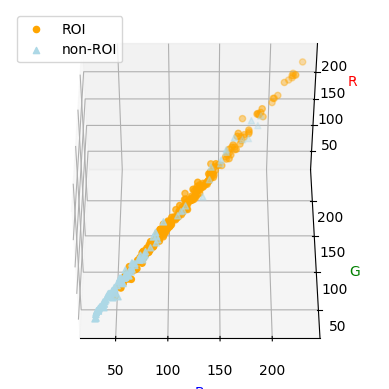

'Using average values of each BGR channels, one can see the distribution of two group is different. \nThe difference may be arise from the use of IR-filter (whick blocks light with wavelength <680nm).\nThis shed a light on using SVM for classifying images into ROI and non-ROI group.\nHowever, the information contained in the avg values is not enough for seperating them, original info. will be used instead of avg. values.'

In [100]:
#Plot avg values of averaged BGR channel values of images

#Create 3D figure
fig = plt.figure()
ax = plt.axes(projection='3d')

#Divide into ROI or non-ROI groups
groupY = np.array(img_avg_list)[maskY]
groupN = np.array(img_avg_list)[maskN]

# Scatter plot for group ROI
ax.scatter(groupY[:, 0], groupY[:, 1], groupY[:, 2], c='orange', marker='o', label='ROI')

# Scatter plot for group non-ROI
ax.scatter(groupN[:, 0], groupN[:, 1], groupN[:, 2], c='lightblue', marker='^', label='non-ROI')

#Adjust viewing angle
ax.view_init(elev=45, azim=270)  # ele = angle of vertical angle, azim = angle of x-y plane

#Set labels
ax.set_xlabel('B').set_color('Blue')
ax.set_ylabel('G').set_color('Green')
ax.set_zlabel('R').set_color('Red')

# Add a legend
ax.legend()

# Show the plot
plt.show()

'''Using average values of each BGR channels, one can see the distribution of two group is different. 
The difference may be arise from the use of IR-filter (whick blocks light with wavelength <680nm).
This shed a light on using SVM for classifying images into ROI and non-ROI group.
However, the information contained in the avg values is not enough for seperating them, original info. will be used instead of avg. values.'''

In [140]:
#SVM model for binary image classification

#Prepare data source
L = img_list_train.shape[0]
img_list_train = img_list_train.reshape(L,-1) #One shape dimension can be -1. This is to flatten images

#Build and train SVM model. Polynomil kernel functions has the best performence on this dataset.
svm_poly = svm.SVC(kernel='poly')
svm_poly.fit(img_list_train, label_list_train)
svm_poly.score(img_list_train,label_list_train)

0.9264705882352942

1228N_0_5.jpg
1228N_2_0.jpg
1228N_2_1.jpg
1305-HDR_normal_0_4.jpg
1305-HDR_normal_1_4.jpg
1305-HDR_normal_1_6.jpg
1305-HDR_normal_1_7.jpg
1310-HDR_normal_0_0.jpg
1310-HDR_normal_0_3.jpg
1310-HDR_normal_0_4.jpg
1310-HDR_normal_1_2.jpg
1310-HDR_normal_1_3.jpg


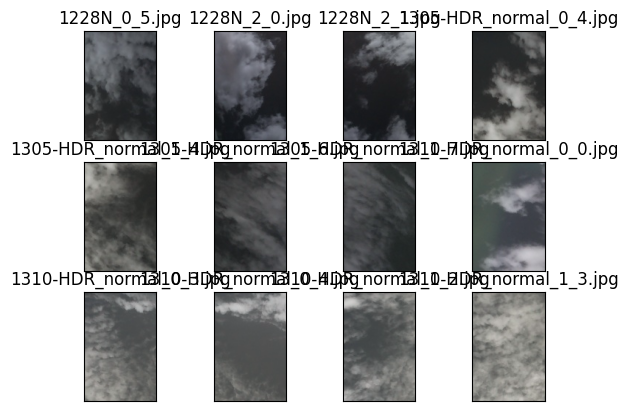

'\nOn test dataset, the accuracy is 75%.\nFirst, check the original data. \nTest label list has 57% of Y, 43% of N, by which we can say that the SVM model perform well over naive guess,\nand orginal Y/N distribution seems has no effect on prediction. \n'

In [216]:
#Examinate the model trained on test data

#Load images
img_list_test = []
for name in df_test['window_name']:
    temp = cv2.imread(os.path.join(test_folder, name))
    img_list_test.append(temp)

img_list_test = np.array(img_list_test,dtype="float32")/255.0    
del temp

#Load labels
label_list_test = df_test["is_ROI"]

#Flatten data
L = img_list_test.shape[0]
img_list_test1 = img_list_test.reshape(L,-1)

#Check accuracy
svm_poly.score(img_list_test1,label_list_test)

#Make prediction
df_test['pred_is_ROI'] = svm_poly.predict(img_list_test1)

#Check unmatched images
temp = df_test[df_test['is_ROI'] != df_test['pred_is_ROI']]
j = 1 #index of df was shuffled, thus need an extra index for now
for i in temp['window_name'][0:12]:
    img = cv2.imread(os.path.join(test_folder,i))
    plt.subplot(3,4,j)
    plt.imshow(img)
    plt.title(i)
    plt.xticks([])
    plt.yticks([])
    j +=1
plt.show()


'''
On test dataset, the accuracy is 75%.
First, check the original data. 
Test label list has 57% of Y, 43% of N, by which we can say that the SVM model perform well over naive guess,
and orginal Y/N distribution seems has no effect on prediction. 

After examining the images, two interim conclusion were made, as following.
1. It seems that SVM model cannot tell high cloud(ex: cirruscumulus) is not ROI.
2. Edge of clouds is likely to be falsely recognised.
'''

In [224]:
 print(temp[temp['is_ROI']  == "Y"])

                  window_name  t_amb  t_dew   qnh  cloud_height       lux  \
5               1228N_0_5.jpg     25     15  1019            80  179841.0   
16              1228N_2_0.jpg     25     15  1019            80  179841.0   
17              1228N_2_1.jpg     25     15  1019           200  179841.0   
28    1305-HDR_normal_0_4.jpg     25     15  1019            65   38978.0   
36    1305-HDR_normal_1_4.jpg     25     15  1019            65   38978.0   
38    1305-HDR_normal_1_6.jpg     25     15  1019            65   38978.0   
39    1305-HDR_normal_1_7.jpg     25     15  1019            65   38978.0   
48    1310-HDR_normal_0_0.jpg     25     15  1019            65   19341.0   
80   20231120-154428N_1_0.jpg     24     15  1018            55   23169.0   
87   20231120-154428N_2_3.jpg     24     15  1018            55   23169.0   
96   20231120-154755N_0_4.jpg     24     15  1018            55   26829.0   
99   20231120-154755N_0_7.jpg     24     15  1018            55   26829.0   